In [46]:
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.preprocessing as pre
from sklearn.pipeline import make_pipeline
from transforming import WithSelected, DFPowerTransform

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [40]:
# distributions overview
def distributions(X, *, cols, figsize=(6, 6), showstat=False, bins=None):
    columns = X.columns[~X.columns.isin(('id', 'target'))]
    rows = len(columns) // cols + bool(len(columns) % cols)

    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    for num, field in enumerate(columns):
        col = num % cols
        row = num // cols
        a = X.loc[X.target == 0, field]
        t = X.loc[X.target == 1, field]
        
        ax[row, col].hist(a, edgecolor='black', alpha=0.7, label='0', bins=bins)
        ax[row, col].hist(t, edgecolor='black', alpha=0.7, label='1', bins=bins)
        if showstat:
            ax[row, col].axvline(X[field].mean(), color='green', label='common mean')
            ax[row, col].axvline(a.mean(), color='blue', label='0 (mean)')
            ax[row, col].axvline(t.mean(), color='purple', label='1 (mean)')

            ax[row, col].axvline(X[field].median(), ls='dashed', color='green', label='common median')
            ax[row, col].axvline(a.median(), ls='dashed', color='blue', label='0 (median)')
            ax[row, col].axvline(t.median(), ls='dashed', color='purple', label='1 (median)')

        ax[row, col].set_title(field)
        ax[row, col].legend()
    fig.tight_layout(pad=2.5, h_pad=1.0)
    plt.suptitle(f'Distributions by target')
    plt.show()

In [3]:
df = pd.read_csv('data/train.csv')
df.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [3]:
df.describe()

,id,gravity,ph,osmo,cond,urea,calc,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,206.500000,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638,0.444444
std,119.655756,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641,0.497505
min,0.000000,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,103.250000,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000,0.000000
50%,206.500000,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000,0.000000
75%,309.750000,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000,1.000000
max,413.000000,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [24]:
# classes balance
df.target.value_counts()

0    230
1    184
Name: target, dtype: int64

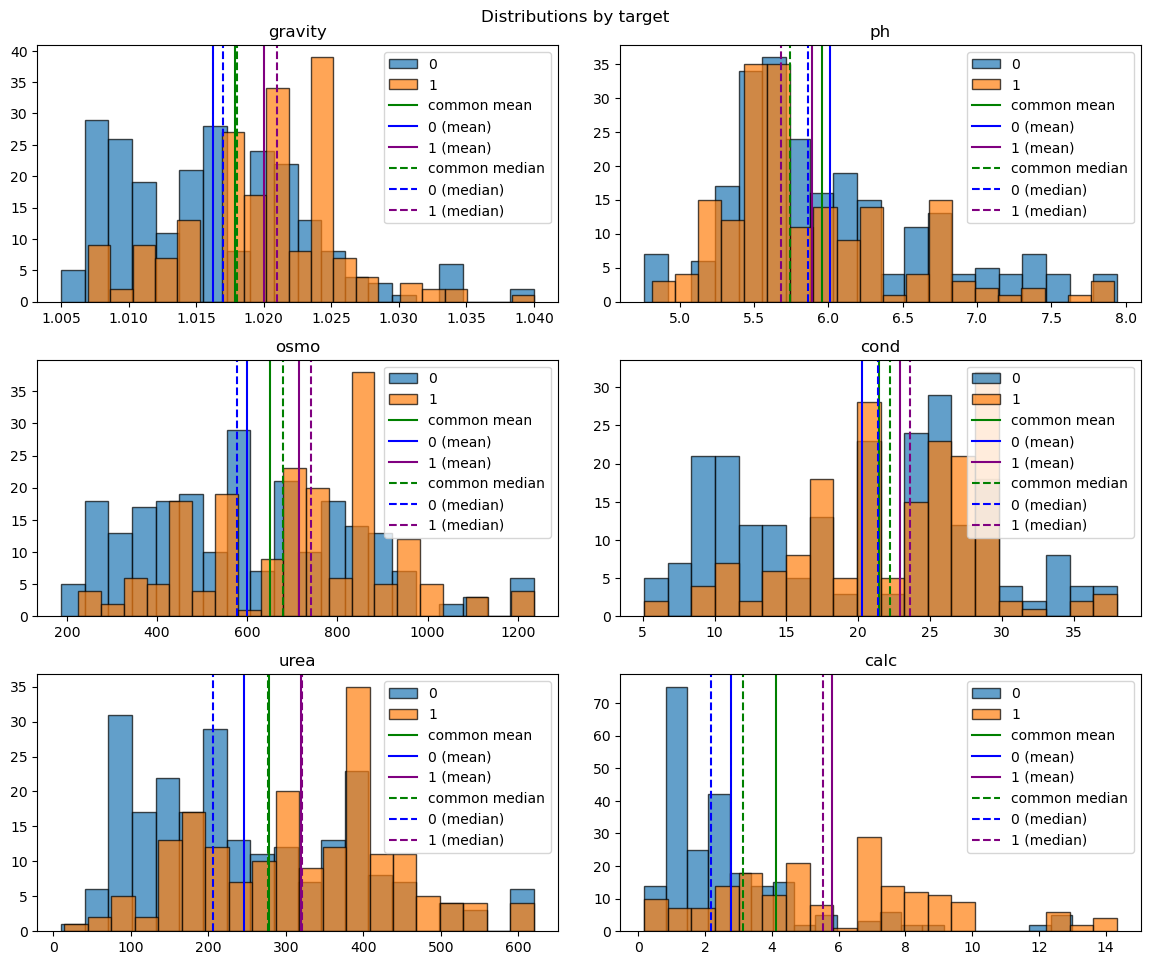

In [42]:
# distributions overview
distributions(df, cols=2, figsize=(12, 10), showstat=True, bins=20)

## preprocessing

In [32]:
original = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
pipe = make_pipeline(
    WithSelected(original, 'pow')(
        DFPowerTransform()
    ),
    WithSelected(['gravity', 'gravity_pow'], suffix='bins')(
        pre.KBinsDiscretizer(7, encode='ordinal', strategy='quantile')
    ),
    WithSelected(['ph', 'ph_pow'], suffix='bins')(
        pre.KBinsDiscretizer(7, encode='ordinal', strategy='quantile')
    ),
    WithSelected(['osmo', 'osmo_pow'], suffix='bins')(
        pre.KBinsDiscretizer(10, encode='ordinal', strategy='quantile')
    ),
    WithSelected(['cond', 'cond_pow'], suffix='bins')(
        pre.KBinsDiscretizer(5, encode='ordinal', strategy='quantile')
    ),
    WithSelected(['urea', 'urea_pow'], suffix='bins')(
        pre.KBinsDiscretizer(10, encode='ordinal', strategy='quantile')
    ),
    WithSelected(['calc', 'calc_pow'], suffix='bins')(
        pre.KBinsDiscretizer(5, encode='ordinal', strategy='quantile')
    ),
)

X = pipe.fit_transform(df)
X.head()

,id,gravity,ph,osmo,cond,urea,calc,target,gravity_pow,ph_pow,...,ph_bins,ph_pow_bins,osmo_bins,osmo_pow_bins,cond_bins,cond_pow_bins,urea_bins,urea_pow_bins,calc_bins,calc_pow_bins
0,0,1.013,6.19,443,14.8,124,1.45,0,-0.715963,0.561764,...,5.0,5.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1,1.025,5.40,703,23.6,394,4.18,0,1.068414,-0.925220,...,1.0,1.0,5.0,5.0,2.0,2.0,7.0,7.0,3.0,3.0
2,2,1.009,6.13,371,24.5,159,9.04,0,-1.390925,0.472669,...,4.0,4.0,1.0,1.0,3.0,3.0,2.0,2.0,4.0,4.0
3,3,1.021,4.91,442,20.8,398,6.63,1,0.511126,-2.325350,...,0.0,0.0,2.0,2.0,2.0,2.0,8.0,8.0,3.0,3.0
4,4,1.021,5.53,874,17.8,385,2.21,1,0.511126,-0.626023,...,2.0,2.0,8.0,8.0,1.0,1.0,7.0,7.0,1.0,1.0


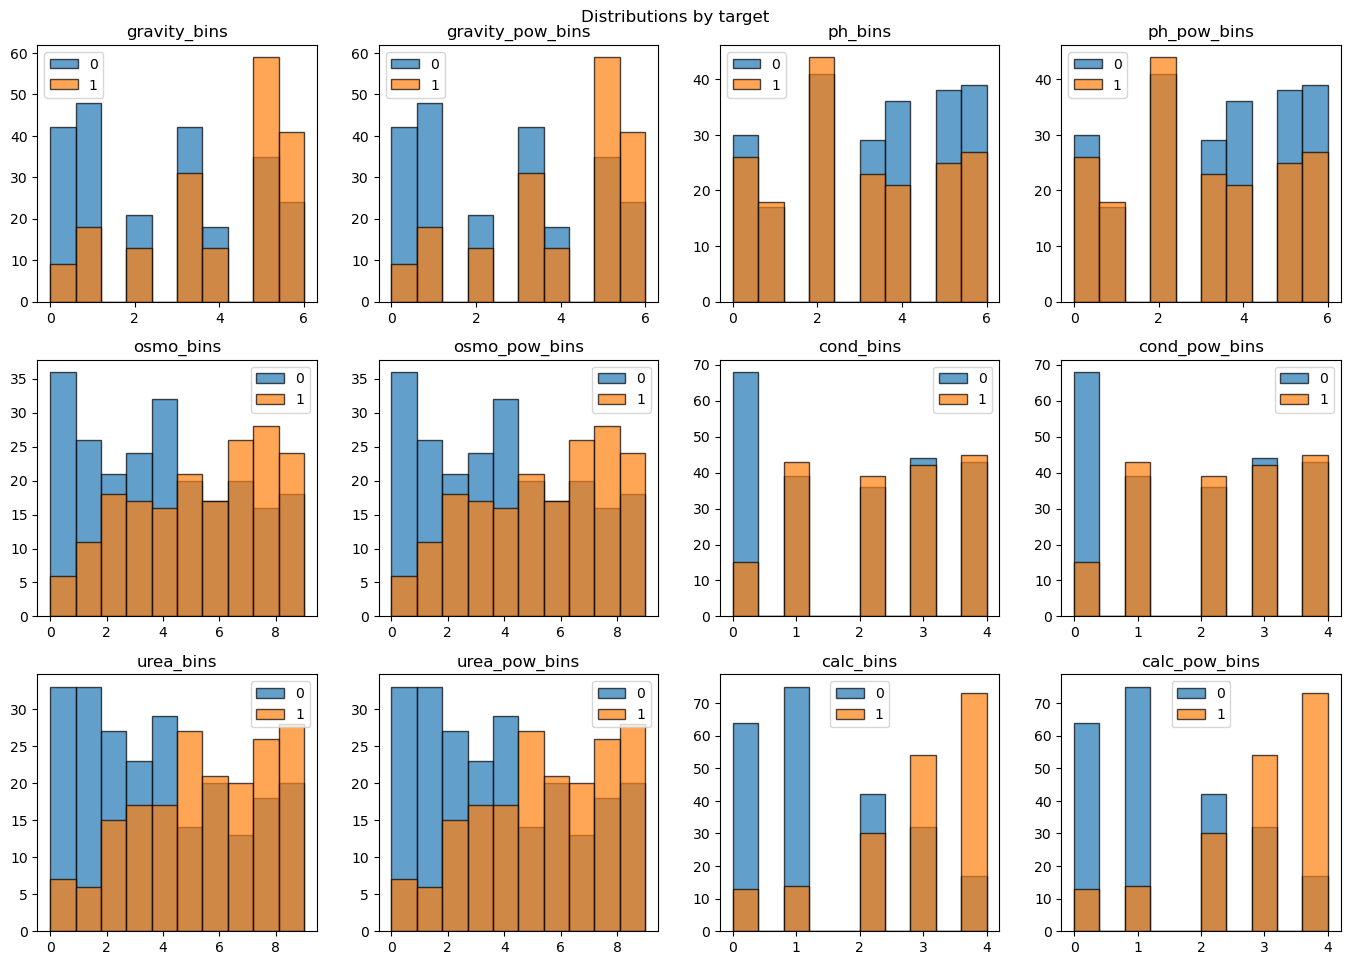

In [45]:
# target Bins by target distributions
selection = [col for col in X.columns if col.endswith('_bins')] + ['target']
distributions(X[selection], cols=4, figsize=(14,10))

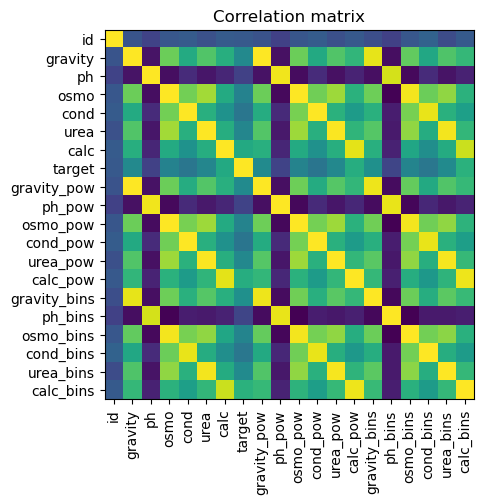

In [29]:
# correlation
plt.figure()
plt.title('Correlation matrix')
plt.xticks(ticks=range(X.columns.size), labels=X.columns, rotation=90)
plt.yticks(ticks=range(X.columns.size), labels=X.columns)
plt.imshow(X.corr());

In [ ]:
#